# Pendulum on a Cart - LQR/Kalman Filter

## Objectives

1.  Derive the linearized equations of motion for a pendulum on a cart dynamics.
2.  Design LQR controller to stabilize the hanging equilibrium
3.  Implement Kalman Filter

## Python Control System Toolbox


In [221]:
pip install control

8611.71s - pydevd: Sending message related to process being replaced timed-out after 5 seconds

[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Pendulum on Cart

Consider a pendulum on a cart model as illustrated below.

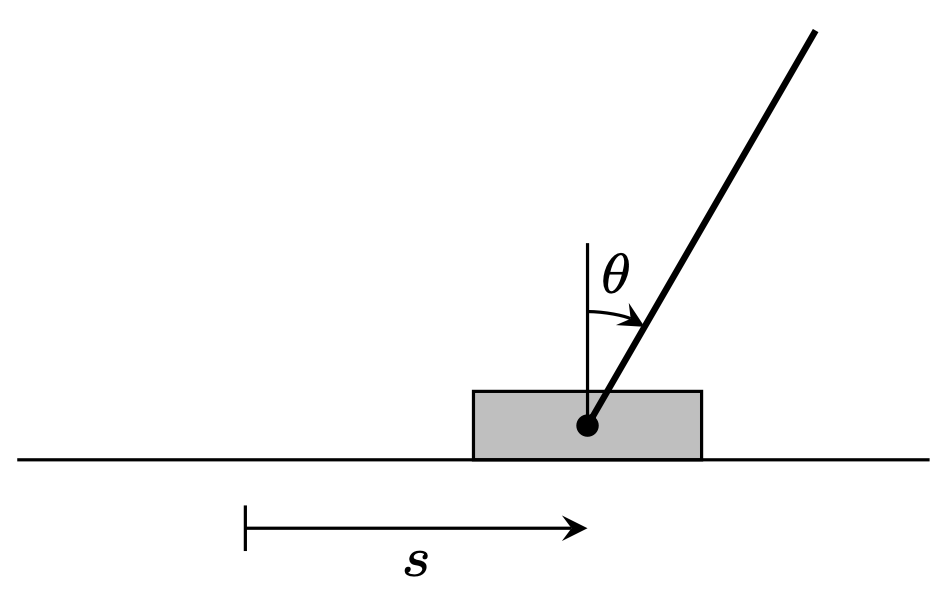

### Equations of Motion

After non-dimensionalizing the variables and the time, the equations of motion can be written as

\begin{align*}
\ddot \theta & = \frac{1}{1+c\sin^2\theta}(-c\dot\theta^2\sin\theta\cos\theta + \sin\theta - \cos\theta u),\\
\ddot s & = \frac{1}{1+c\sin^2\theta}( (1+c)\dot\theta^2 - \sin\theta\cos\theta + b u),
\end{align*}
where $b, c\in\Re$ are constant parameters that can be determined by the mass and length properties, and $u\in\Re$ is the control force acting on the cart.

### State Variables

Let the state variables $x\in\Re^4$ and the output variable $y\in\Re^2$ be

\begin{align*}
x & = [x_1, x_2, x_3, x_3] = [\theta, \dot\theta, s, \dot s],\\
 y & = [\theta, s]
\end{align*}

### Nonlinear State Equation

In the modeling, the equations of motion are reformulated in to the state equation, given by $\dot x = f (t, x, u)$ and $y=g(t,x,u)$. 

This can be formulated in python by [control.NonlinearIOSystem()](https://python-control.readthedocs.io/en/0.9.4/generated/control.NonlinearIOSystem.html#control.NonlinearIOSystem) with the usuage of

```control.NonlinearIOSystem(updfcn, outfcn=None, params=None, **kwargs)```

where 

* `updfcn(t, x, u, params)` is a python function for $f(t,x,u)$ with an additional parameter
* `outfcn(t, x, u, params)` is a python function for $g(t,x,u)$ with an additional parameter

Suppose $b=3$ and $c=0.5$.
Complete the following code to define a python model for the pendulum on car, as we did in Recitation 2.

**NOTE**: In the above functions, `updfcn`, `outfcn`, it is considered that both of `x` and `u` are array-like. Consequently, the input must be referenced as `u[0]` inside of the function, insteand of `u`.



In [222]:
import control
import numpy as np
import matplotlib.pyplot as plt

params = {"b": 3., "c": 0.5}
def pendulum_cart_eom(t, x, u, params):
    b = params['b']
    c = params['c']

    theta, theta_dot, s, s_dot = x[0], x[1], x[2], x[3]

    theta_ddot = (-c*theta_dot**2*np.sin(theta)*np.cos(theta)+np.sin(theta)-np.cos(theta)*u[0])/(1+c*np.sin(theta)**2)
    s_ddot = ((1+c)*theta_dot**2 - np.sin(theta)*np.cos(theta) + b*u[0])/(1+c*np.sin(theta)**2)

    x_dot = np.array([theta_dot, theta_ddot, s_dot, s_ddot])
    
    return x_dot

def pendulum_cart_output(t, x, u, params):
    return x

# define a nonlinear dynamic model (the second and the third lines are optional)
sys_pendulum_cart = control.NonlinearIOSystem(updfcn = pendulum_cart_eom, outfcn=pendulum_cart_output, \
                                         states=('angle', 'angular_velocity', 'position', 'velocity'), \
                                         output=('angle', 'angular_velocity', 'position', 'velocity'), inputs=('force'), \
                                         name='pendulum_cart')

print(sys_pendulum_cart)


<NonlinearIOSystem>: pendulum_cart
Inputs (1): ['force']
Outputs (4): ['angle', 'angular_velocity', 'position', 'velocity']
States (4): ['angle', 'angular_velocity', 'position', 'velocity']

Update: <function pendulum_cart_eom at 0x16c530040>
Output: <function pendulum_cart_output at 0x16c531940>


### Linearization

The hanging equililbrium is given by 

\begin{align*}
x^* = [\pi, 0, 0, 0],\quad u^*=0.
\end{align*}

Find the linearized equations of motion, or the linear state-spade model using [control.linearize()](https://python-control.readthedocs.io/en/latest/generated/control.linearize.html). 

Print out the matrices $A,B,C$ and $D$ and verity that they are close to

\begin{gather*}
A = \begin{bmatrix}
0 & 1 & 0 & 0 \\
-1 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 \\
-1 & 0 & 0 & 0
\end{bmatrix}, 
\quad
B = \begin{bmatrix} 0 \\ 1 \\ 0 \\ 3 \end{bmatrix},\\
C = I_{4\times 4}, \quad D=0_{4\times 1}
\end{gather*}


In [223]:
x_star = np.array([np.pi, 0., 0., 0.])
u_star = [0]

syslin_pendulum_cart = control.linearize(sys_pendulum_cart, x_star, u_star, params=params)
syslin_pendulum_cart.C = np.eye(4)
syslin_pendulum_cart.D = np.zeros((4,1))
print(syslin_pendulum_cart)



<LinearIOSystem>: sys[131]
Inputs (1): ['u[0]']
Outputs (4): ['y[0]', 'y[1]', 'y[2]', 'y[3]']
States (4): ['x[0]', 'x[1]', 'x[2]', 'x[3]']

A = [[ 0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00]
     [-1.00000000e+00  6.12353278e-23  0.00000000e+00  0.00000000e+00]
     [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]
     [-1.00000000e+00  1.50000000e-06  0.00000000e+00  0.00000000e+00]]

B = [[0.]
     [1.]
     [0.]
     [3.]]

C = [[1. 0. 0. 0.]
     [0. 1. 0. 0.]
     [0. 0. 1. 0.]
     [0. 0. 0. 1.]]

D = [[0.]
     [0.]
     [0.]
     [0.]]



### Uncontrolled Dynamics

The uncontrolled dynamics from a given inital condition can be simulated by [`control.input_output_response()`](https://python-control.readthedocs.io/en/latest/generated/control.input_output_response.html).

Recall that the linearized dynamics simulates the perturbantion $\delta x = x - x^*$. Therefore, after simulting the linearized dynamcis to obtain $\delta x(t)$, it shold be converted back to the original state $x(t) = x^* + \delta x(t)$.

/opt/homebrew/lib/python3.11/site-packages/control/iosys.py:694: UserWarning: Parameters passed to LinearIOSystems are ignored.
  warn("Parameters passed to LinearIOSystems are ignored.")


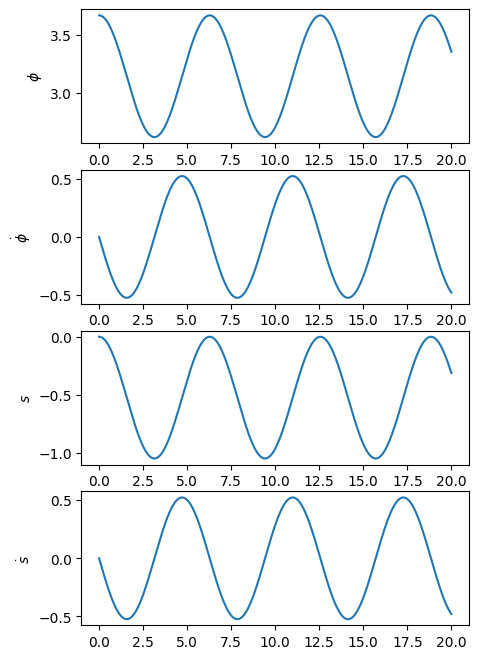

In [224]:
t = np.linspace(0, 20, 501)
sim_data = control.input_output_response(syslin_pendulum_cart, T=t, X0=[np.pi/6, 0, 0, 0], params=params)
delta_x = sim_data.x
x = delta_x + x_star[:, None]


def plot_state(t,x):
    plt.figure(figsize=(5,8))
    ylabels = ['$\phi$', '$\dot\phi$', '$s$', '$\dot s$']
    for i in range(4):
        axi = plt.subplot(4, 1, i+1)
        axi.plot(t, x[i])
        axi.set_ylabel(ylabels[i])


%matplotlib inline
plot_state(t,x)


501


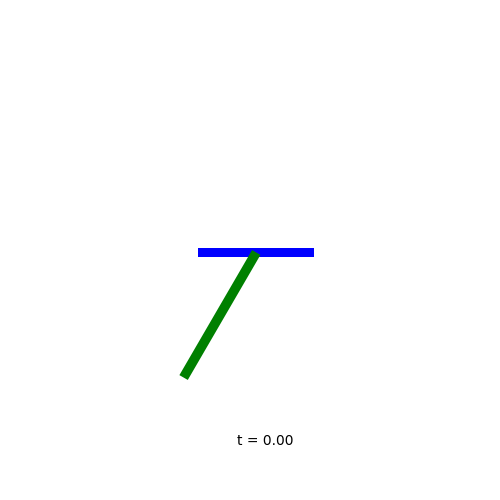

In [225]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import matplotlib.animation as animation
import matplotlib.patches as patches

%matplotlib widget
def ani_pend_cart(x):
    phi = x[0] 
    s = x[2]
    print(phi.shape[0])

    # generate animation
    w = 0.6
    h = 0.1
    pw = 0.05
    ph = 1.5
    vertices0_cart = np.array([ [-w,h/2], [w, h/2], [w, -h/2], [-w, -h/2] ]).T
    vertices0_pend = np.array([ [-pw,ph], [pw, ph], [pw, 0], [-pw, 0] ]).T

    def compute_R(angle):
        return np.array([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]])
    def compute_vertices(i):
        vertices_cart = vertices0_cart.copy()
        vertices_cart[0,:]+=s[i]
        vertices_pend = compute_R(phi[i]) @ vertices0_pend.copy()
        vertices_pend[0,:]+=s[i]
        return vertices_pend, vertices_cart

    vertices_pend, vertices_cart = compute_vertices(0)
    patch_cart = Polygon(vertices_cart.T, facecolor = 'b')
    patch_pend = Polygon(vertices_pend.T, facecolor = 'g')

    fig = plt.figure(figsize = (5,5))
    ax = plt.gca()
    ax.add_patch(patch_cart)
    ax.add_patch(patch_pend)
    text_t = ax.text(-0.2,-2, f't = {t[0]:.2f}')
    ax.set_xlim([-2,2])
    ax.set_ylim([-2,2])
    ax.axis('off')
    plt.show()

    def init():
        return patch_pend, patch_cart

    def animate(i):

        vertices_pend, vertices_cart = compute_vertices(i)
        patch_cart.set_xy(vertices_cart.T)
        patch_pend.set_xy(vertices_pend.T)
        text_t.set_text(f't = {t[i]:.2f}')
        return patch_pend, patch_cart

    ani = animation.FuncAnimation(fig, animate, phi.shape[0], init_func=init, interval=2, repeat=False)
    return ani

ani = ani_pend_cart(x)


## LQR Design

Choose $Q\in\Re^{4\times 4}$ and $R\in\Re^1$. Using the python function [`control.lqr`](https://python-control.readthedocs.io/en/latest/generated/control.lqr.html), find the gain matrix $K\in\Re^{4\times 1}$.

In [226]:
Q = np.diag([10, 1, 1, 1])
R = 1

K, _, _ = control.lqr(syslin_pendulum_cart, Q, R)

print(K)

[[ 2.59159293 -1.82588055  1.          2.14280025]]


The controlled system can be defined by [`control.create_statefbk_iosystem`](https://python-control.readthedocs.io/en/latest/generated/control.create_statefbk_iosystem.html#control.create_statefbk_iosystem)

In [227]:
ctrlin_lqr, syslin_lqr = control.create_statefbk_iosystem(syslin_pendulum_cart, K)

## Kalman Filter

The above LQR control is a state feedback, and therefore it requires the complete state for implementation. Here we implement a Kalman filter to estimate the complete state with the measurements of the angle of the pendulum and the position of the cart. 

The measurement equation is given by

\begin{align*}
z = [\phi, s]^T = H x\in\Re^2
\end{align*}
where $H\in\Re^{2\times 4}$ is 
\begin{align*}
H = \begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & 0 & 1 & 0 \end{bmatrix}.
\end{align*}

The Kalman filter equation is given by

\begin{gather*}
\dot{\hat x} = A \hat x + B u + L(z - H \hat x)\\
\dot S = A S + S A^T + W - KVK^T
\end{gather*}
where $x\sim\mathcal{N}(\hat x, S)$, and $W,V$ corresponds to the covariance matrix of the process noise and the measurement noise respectively, and the Kalman gain is given by $L=SH^T V^{-1}$. This can be simplified with steady-state assumption, i.e., $\dot S=0$.

The value of the Kalman gain can be computed by [`control.lqe()`](https://python-control.readthedocs.io/en/latest/generated/control.lqe.html). To simulate the integrated LQR and Kalman filter, we formulate the following augmented system:

\begin{align*}
\begin{bmatrix} \dot x \\ \dot{\hat{x}} \end{bmatrix}
=
\begin{bmatrix} A & -BK \\ LH & A - BK-LH \end{bmatrix}
\begin{bmatrix} x \\ \hat x\end{bmatrix}.
\end{align*}


In [228]:
H = np.array([[1, 0, 0, 0], [0, 0, 1, 0]])
W = 0.1**2 * np.eye(4)
V = np.diag([0.1, 0.1])**2
L = control.lqe(syslin_pendulum_cart.A, np.eye(4), H, W, V)[0]
print(L)

A = syslin_pendulum_cart.A
B = syslin_pendulum_cart.B

AA = np.block([[A, -B@K], [L@H, A-B@K-L@H]])
syslin_lqr_kf = control.ss(AA, np.zeros((8,1)), np.block([np.zeros((1,4)), -K]), 0)

[[ 1.32566648 -0.08281782]
 [ 0.3821252   0.29954954]
 [-0.08281782  1.92005249]
 [-0.56835292  1.34673018]]


The simulation results for Kalman filter are given as follows.
* red: LQR with the assumption that the state is exactly known
* blue: LQR implemented with the state estimated by Kalman filter
* blue-dotted: estiamted state

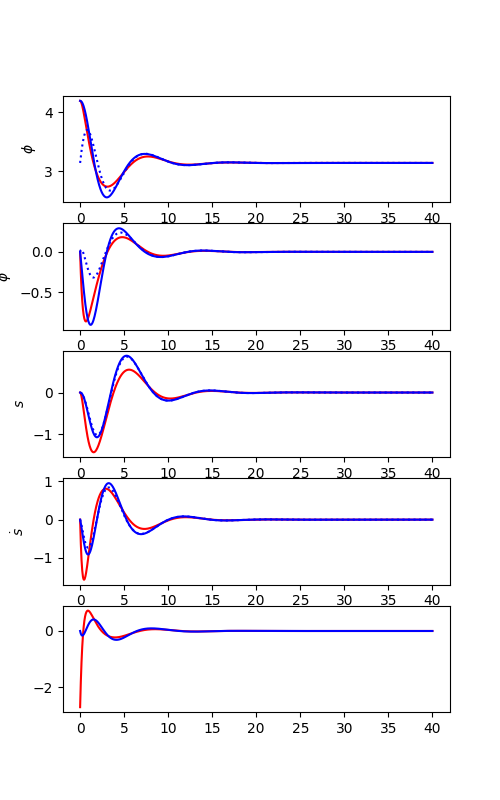

In [229]:
t = np.linspace(0, 40, 1001)
x0 = np.array([np.pi/3, 0, 0, 0])
xhat0 = np.array([0, 0, 0, 0])
sim_data = control.input_output_response(syslin_lqr, t, X0=x0)
sim_data_kf = control.input_output_response(syslin_lqr_kf, t, X0=np.block([x0, xhat0]))

x = sim_data.x + x_star[:, None]
u = sim_data.y[4]
x_kf = sim_data_kf.x[0:4] + x_star[:, None]
x_hat_kf = sim_data_kf.x[4:] + x_star[:, None]
u_kf = sim_data_kf.y[0]

plt.figure(figsize=(5,8))
ylabels = ['$\phi$', '$\dot\phi$', '$s$', '$\dot s$']
for i in range(4):
    axi = plt.subplot(5, 1, i+1)
    axi.plot(t, x[i], 'r', t, x_kf[i], 'b', t, x_hat_kf[i], 'b:')
    axi.set_ylabel(ylabels[i])
ax4 = plt.subplot(5, 1, 5)
ax4.plot(t, u, 'r', t, u_kf, 'b')

1001


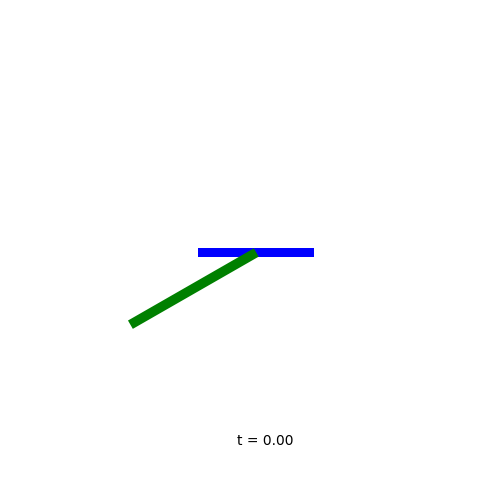

In [230]:
ani_pend_cart(x_kf)